In [1]:
from sigvisa.treegp.gp import GPCov, GP, prior_sample, mcov
import pyublas


# Variational inference

In [2]:
from sigvisa.models.spatial_regression.gp_uncertain_inputs_variational_autograd import UncertainInputGP, cov_matrix, compute_Psi1, compute_Psi2
import scipy.stats

In [3]:
p_means = [np.array((-1.0,)), np.array((0.0,)), np.array((1.0,))]
p_covs = [np.array(((1.0,),)), np.array(((1.0,),)), np.array(((1.0,),))]
theta = np.array([1.0, 1.0])

Y = np.array(((4,), (4,), (0,)))

Xu = np.array((-1, 0, 1)).reshape((-1, 1))

sigma2_n=0.1

# Psi1 is expectation of K_xu under q(x)
# so it should be equal to the actual cov if we set variances to zero
p_covs_zero = [np.array(((0.0,),)), np.array(((0.0,),)), np.array(((0.0,),))]
P1 = compute_Psi1(p_means, p_covs_zero, Xu, theta)
C = cov_matrix(np.array(p_means).reshape(-1, 1), Xu, theta)
print P1-C

# similarly we can test Psi2
P2 = compute_Psi2(p_means, p_covs_zero, Xu, theta)
print P2- np.dot(C.T, C)



[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]


In [4]:
uigp = UncertainInputGP(p_means, p_covs, Y)

xm, xv, Xu = uigp.locate_inputs(Xu, theta, sigma2_n)
print xm
print xv
print Xu

[ 10.40267943   0.65208786  -1.24525972  -6.11907333  10.87055207
 -14.56096517  20.55680775  12.44376509   8.62635969]
[ 10.40267565   0.65208549  -1.24526173  -6.11908191  10.87054887
 -14.56096637  20.55680659  12.44376023   8.62636962]
[array([-0.85379526]), array([-0.7797678]), array([ 1.63356308])]
[array([[ 0.07195861]]), array([[ 0.066616]]), array([[ 0.06626864]])]
[[-1.86134347]
 [-0.6910662 ]
 [ 1.62890846]]


In [5]:
X_obs = np.array(p_means)
print uigp.likelihood(X_obs.reshape((-1, 1)), theta, sigma2_n)

mhXs, lls = uigp.mh(X_obs, theta, sigma2_n)

-16.7529719807
step 0, accept rate 0.000000, lp -16.752972
step 50, accept rate 0.588235, lp -16.032499
step 100, accept rate 0.554455, lp -14.102434
step 150, accept rate 0.509934, lp -13.664164
step 200, accept rate 0.457711, lp -13.796296
step 250, accept rate 0.466135, lp -13.223336
step 300, accept rate 0.481728, lp -13.966691
step 350, accept rate 0.490028, lp -13.520041
step 400, accept rate 0.496259, lp -14.188808
step 450, accept rate 0.494457, lp -12.913081
step 500, accept rate 0.487026, lp -12.930700
step 550, accept rate 0.500907, lp -14.113852
step 600, accept rate 0.509151, lp -14.308811
step 650, accept rate 0.505376, lp -13.283690
step 700, accept rate 0.507846, lp -14.096655
step 750, accept rate 0.509987, lp -12.947108
step 800, accept rate 0.504370, lp -13.815504
step 850, accept rate 0.506463, lp -15.519692
step 900, accept rate 0.504994, lp -13.753223
step 950, accept rate 0.505783, lp -13.872711
step 1000, accept rate 0.503497, lp -14.701643
step 1050, accept rat

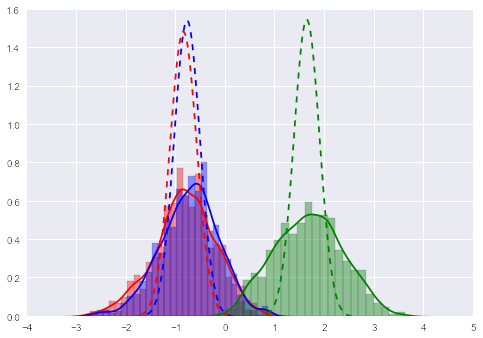

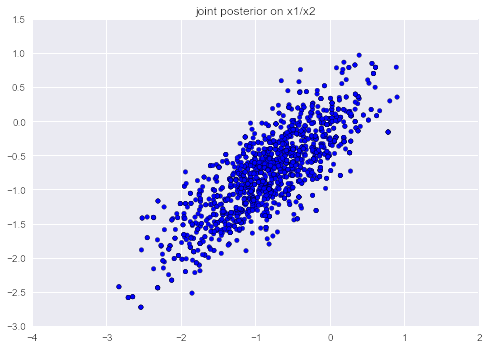

In [6]:
np.mean(mhXs[200:], axis=0)

import seaborn as sns

def plot_gaussian(m, v, **kwargs):
    s = np.sqrt(v[0])
    xs = np.linspace(m-4*s, m+4*s, 100)
    ps = scipy.stats.norm(loc=m, scale=s).pdf(xs)
    plot(xs, ps, **kwargs)
    
    
sns.distplot(mhXs[200:,0], color="red")
sns.distplot(mhXs[200:,1], color="blue")
sns.distplot(mhXs[200:,2], color="green")

plot_gaussian(xm[0], xv[0], color="red", ls='--')
plot_gaussian(xm[1], xv[1], color="blue", ls='--')
plot_gaussian(xm[2], xv[2], color="green", ls='--')


figure()
scatter(mhXs[200:,0], mhXs[200:,1])
title("joint posterior on x1/x2")

In [3]:
# more interesting setup: 2d world, a line? of events, and let's say a 5d output space
# 
sigma2_n = 0.01
true_X = np.array(( (-2.0, 0.0),\
                    (-1.0, 0.0),\
                    (0.0, 0.0),\
                    (1.0, 0.0),\
                    (2.0, 0.0),))

n = true_X.shape[0]
theta = np.array([1.0, 5.0, 5.0])
C = cov_matrix(true_X, true_X, theta) + sigma2_n*np.eye(n)
ys = scipy.stats.multivariate_normal(mean=np.zeros((n,)), cov=C).rvs(20).T

obs_x = [x+np.random.randn(2)*.5 for x in true_X]
obs_cov = [np.eye(2)*.25 for x in true_X]



In [4]:
uigp = UncertainInputGP(obs_x, obs_cov, ys)
mhXs, lls = uigp.mh(np.array(true_X), theta, sigma2_n, std=0.1, steps=4000)

step 0, accept rate 0.000000, lp -54.559532
step 50, accept rate 0.352941, lp -54.305616
step 100, accept rate 0.405941, lp -55.911673
step 150, accept rate 0.350993, lp -58.287147
step 200, accept rate 0.343284, lp -57.056250
step 250, accept rate 0.326693, lp -54.589019
step 300, accept rate 0.315615, lp -55.443503
step 350, accept rate 0.293447, lp -52.872301
step 400, accept rate 0.306733, lp -55.825095
step 450, accept rate 0.305987, lp -53.786206
step 500, accept rate 0.305389, lp -54.664988
step 550, accept rate 0.294011, lp -53.698866
step 600, accept rate 0.292845, lp -55.925206
step 650, accept rate 0.288786, lp -53.823896
step 700, accept rate 0.283880, lp -55.347134
step 750, accept rate 0.282290, lp -55.834647
step 800, accept rate 0.275905, lp -55.892936
step 850, accept rate 0.272620, lp -55.261591
step 900, accept rate 0.274140, lp -54.960032
step 950, accept rate 0.276551, lp -55.385080
step 1000, accept rate 0.274725, lp -53.906779
step 1050, accept rate 0.274025, lp 

In [5]:
mcmc_means = np.mean(mhXs[1000:,:,:], axis=0)
avg_var =  np.mean(np.var(mhXs[1000:,:,:], axis=0))

Xu = np.array(mcmc_means[[0,4],:])

xm, xv, Xu = uigp.locate_inputs(Xu, theta, sigma2_n, x_init=mcmc_means, init_std=np.sqrt(avg_var))
print xm
print xv
print Xu


[ -4.21555902e+02   2.06753241e+02   2.40073124e+02   2.79310375e+02
   4.07211473e-02  -1.25525708e+00   1.73866723e+02  -1.41974991e+02
   1.19693649e+02  -1.84922288e+02  -7.13969228e+01  -1.47629857e+02
  -4.18083497e+01  -1.05954317e+01   9.46355997e+01  -2.90500105e+00
   1.05177131e+02   5.68703377e+01  -8.91949765e+00   1.00122841e+02
   2.13131825e+01  -1.94558591e+01   8.31508437e+01   5.90712487e+01
  -1.60826473e+01   9.40121138e+01   1.21123688e+02   1.96595687e+00
   1.13990840e+02]
[ -4.21556146e+02   2.06752834e+02   2.40072845e+02   2.79310046e+02
   4.05759761e-02  -1.25543450e+00   1.73866649e+02  -1.41975160e+02
   1.19693641e+02  -1.84922426e+02  -7.13969910e+01  -1.47630013e+02
  -4.18085322e+01  -1.05956228e+01   9.46354469e+01  -2.90516073e+00
   1.05176958e+02   5.68702366e+01  -8.91959553e+00   1.00122673e+02
   2.13131382e+01  -1.94558988e+01   8.31507021e+01   5.90711480e+01
  -1.60827463e+01   9.40119590e+01   1.21123496e+02   1.96575671e+00
   1.13990656e+

In [6]:
from matplotlib.patches import Ellipse

def plot_2d_locations(mhXs, true_X, obs_x, xm, xv, ylim=None, xlim=None, ax=None):
    
    ax = gca() if ax is None else ax
    
    cs = ["red", "orange", "green", "blue", "purple", "brown", "pink", "yellow"]
    n = true_X.shape[0] if true_X is not None else len(xm) if xm is not None else mhXs[0].shape[0] if mhXs is not None else len(obs_x[0])
    
    if mhXs is not None:
        mhXsT = np.array(mhXs)
        for i in range(n):
            ax.scatter(mhXsT[1000:, i, 0], mhXsT[1000:, i, 1], color=cs[i], alpha=0.02)

    if true_X is not None:
        for i in range(n):
            ax.scatter(true_X[i,0], true_X[i,1], color=cs[i], marker="*", s=100)

    if obs_x is not None:
        for i in range(n):
            ax.scatter(obs_x[i][0], obs_x[i][1], color=cs[i], marker="^", s=100)

    if xm is not None:
        for i in range(n):
            ax.scatter(xm[i][0], xm[i][1], color=cs[i], marker='*')
            C = xv[i]

            evl, evec = np.linalg.eig(C)
            a = 90-np.arctan(evec[0][1]/evec[0][0]) * 180.0/np.pi
            axes = np.sqrt(evl)*2.0
            e = Ellipse(xy=xm[i], width=axes[1], height=axes[0], angle=a)
            ax.add_artist(e)
            #e.set_clip_box(bmap.ax.bbox)
            e.set_alpha(0.2)
            e.set_facecolor(cs[i])
    if ylim is not None:
        ax.set_ylim(ylim)
    if xlim is not None:
        ax.set_xlim(xlim)
    ax.set_axis_bgcolor('white')
    


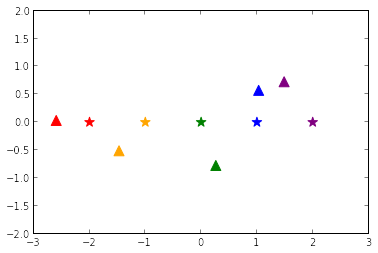

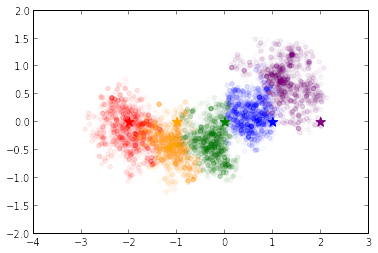

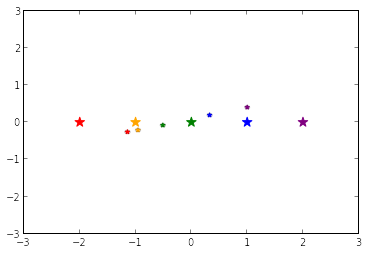

In [7]:
figure()
plot_2d_locations(None, true_X, obs_x, None, None, ylim=[-2.0, 2.0])

figure()
plot_2d_locations(mhXs, true_X, None, None, None, ylim=[-2.0, 2.0])

figure()
plot_2d_locations(None, true_X, None, xm, xv, ylim=[-3.0, 3.0])

In [ ]:
# more interesting setup: 2d world, a circle of events, and let's say a 5d output space
# 
sigma2_n = 0.01
true_X = np.array(( (-2.0, 0.0),\
                    (0.0, 2.0),\
                    (2.0, 0.0),\
                    (0.0, -2.0),\
                    (-1.41, -1.41),\
                    (1.41, 1.41),\
                    (-1.41, 1.41),\
                    (1.41, -1.41),))

n = true_X.shape[0]
theta = np.array([1.0, 5.0, 5.0])
C = cov_matrix(true_X, true_X, theta) + sigma2_n*np.eye(n)
ys = scipy.stats.multivariate_normal(mean=np.zeros((n,)), cov=C).rvs(10).T

obs_x = [x+np.random.randn(2) for x in true_X]
obs_cov = [np.eye(2) for x in true_X]

Xu = np.array(obs_x) #true_X

uigp = UncertainInputGP(obs_x, obs_cov, ys)
xm, xv, Xu = uigp.locate_inputs(Xu, theta, sigma2_n)
print xm
print xv

In [20]:
mhXs, lls = uigp.mh(np.array(true_X), theta, sigma2_n, std=0.1, steps=4000)

step 0, accept rate 1.000000, lp -90.616854
step 50, accept rate 0.352941, lp -87.491873
step 100, accept rate 0.386139, lp -84.923013
step 150, accept rate 0.397351, lp -88.132747
step 200, accept rate 0.432836, lp -91.322775
step 250, accept rate 0.438247, lp -87.944457
step 300, accept rate 0.441860, lp -88.844739
step 350, accept rate 0.444444, lp -86.983611
step 400, accept rate 0.433915, lp -87.737007
step 450, accept rate 0.439024, lp -90.446941
step 500, accept rate 0.449102, lp -97.305854
step 550, accept rate 0.462795, lp -96.493181
step 600, accept rate 0.474210, lp -94.321672
step 650, accept rate 0.470046, lp -92.996211
step 700, accept rate 0.472183, lp -92.974355
step 750, accept rate 0.476698, lp -87.842409
step 800, accept rate 0.473159, lp -89.051477
step 850, accept rate 0.474736, lp -87.559002
step 900, accept rate 0.471698, lp -94.367078
step 950, accept rate 0.473186, lp -92.202237
step 1000, accept rate 0.466533, lp -92.469377
step 1050, accept rate 0.467174, lp 

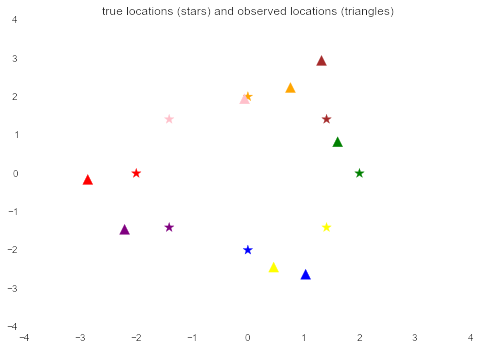

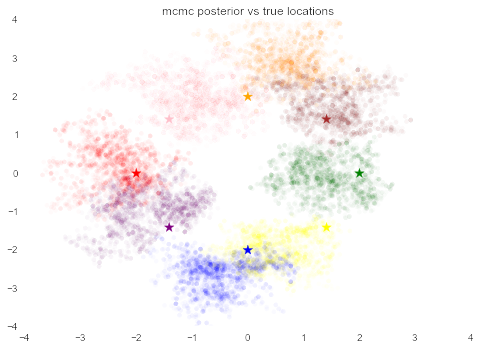

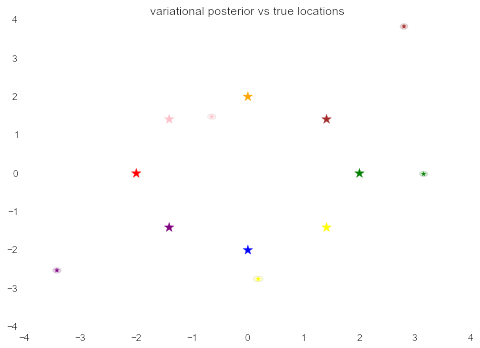

In [21]:
plot_2d_locations(None, true_X, obs_x, None, None, ylim=[-4, 4], xlim=[-4, 4])
title("true locations (stars) and observed locations (triangles)")


figure()
plot_2d_locations(mhXs, true_X, None, None, None, ylim=[-4, 4], xlim=[-4, 4])
title("mcmc posterior vs true locations")

figure()
plot_2d_locations(None, true_X, None, xm, xv, ylim=[-4, 4], xlim=[-4, 4])
title("variational posterior vs true locations")



In [22]:
uigp = UncertainInputGP(obs_x, obs_cov, ys)
xm, xv, Xu = uigp.locate_inputs(Xu, theta, sigma2_n, x_init=true_X)
print xm
print xv
print Xu

[ -88.0032519     1.24321082   40.8752594    60.50138472  159.66691922
   12.9425971    12.46230363  -29.12057516  -74.25356125  -61.90015893
    8.31321972   47.3712189   -42.8160763   116.36997579   -1.43666534
 -188.20685659   72.9204412     0.53492158   12.65646597  -99.15323949
  -88.55772921    8.29182682  -36.62998574  101.05905949   36.67399187
   39.14913623   -7.40176642  -90.59133822   -3.14080421  -31.01908533
   -1.38038899  111.27412949   10.84245628   -7.42782572   50.27714224
   93.71982696  -17.54367509   77.06975384   41.91888843   -2.6755929
  127.95614384   79.69766034    3.45521767  103.07999059   11.39227766
  -15.22985781   45.23938378   15.61095269   -9.75463081   87.57705564
   59.52389779   -6.64359845   99.32852549   45.91270908  -20.30039195
   75.05104054]
[ -88.00324568    1.24319311   40.87525253   60.50138494  159.66687763
   12.94253911   12.46230632  -29.12057156  -74.25357094  -61.90016299
    8.31321166   47.37123033  -42.81617017  116.36989953   -1.

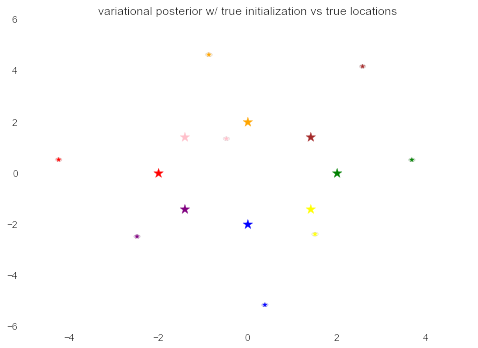

In [26]:
figure()
plot_2d_locations(None, true_X, None, xm, xv)
title("variational posterior w/ true initialization vs true locations")
